# Acknowledgements

The dataset used in this notebok: https://github.com/codebasics/py/blob/master/ML/7_logistic_reg/insurance_data.csv


# Logistic Regression Motivation

In many cases, we need to predict the answer to a yes/no question (e.g., does a patient have cancer?) or classify an object into one of many buckets (e.g., is the animal in the picture a cat, dog, or giraffe?) based on one or several factors.

In such cases, we commonly train a logistic regression model on the dataset. Whereas linear regression predicts a continuous quantity based on input factors, logistic regression is a machine learning model to predict discrete quantities, such as classification or yes/no predictions.

<b>The raw output of a logistical regression model is a probability value</b> (e.g., probability of cancer, probability of image being cat)

# Why not linear regression?

One of the first questions one might ask is whether a new type of model is even necessary. Why is it not possible to just use linear regression and round the predictions to some discrete quantities?

To answer this question, it is important to <i>visualize</i> the type of data that logistic regression is used for.

For this notebook, we will be using a simple insurance dataset. The data contains two columns, the age of the person, and whether that person bought insurance or not (the second column is 1 if the person bought insurance, and 0 otherwise).

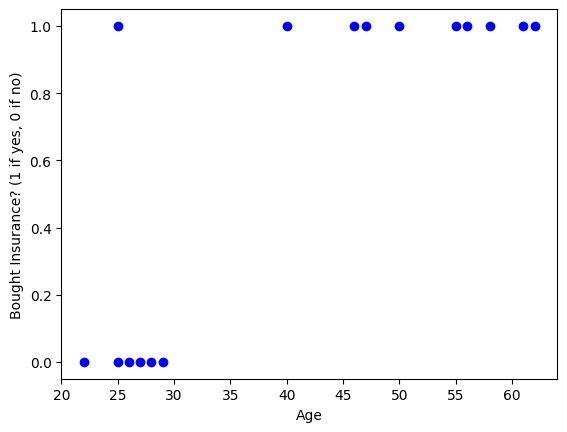

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Importing dataset
df = pd.read_csv('data/insurance_data.csv')

# Train-test split
df_train = df.sample(frac=0.6, random_state=42)  # 80% of the data will be used to train the model
df_test = df.drop(df_train.index)  # Collects remaining 20% and saves it for testing

# Splitting into features and labels
X_train = df_train['age'].values.reshape(-1, 1)
y_train = df_train['bought_insurance'].values
X_test = df_test['age'].values.reshape(-1, 1)
y_test = df_test['bought_insurance'].values

# Plotting the training data
plt.xlabel('Age')
plt.ylabel('Bought Insurance? (1 if yes, 0 if no)')
plt.plot(X_train, y_train, 'bo')
plt.show()

From the plot above, it is evident that the shape of the data does not fit a line. Rather, the data is composed of two “plateaus” -- one composed of all the people who bought insurance, and one of all who did not. 

Still, to make the point clearer, let's try fitting the data to a line regardless.

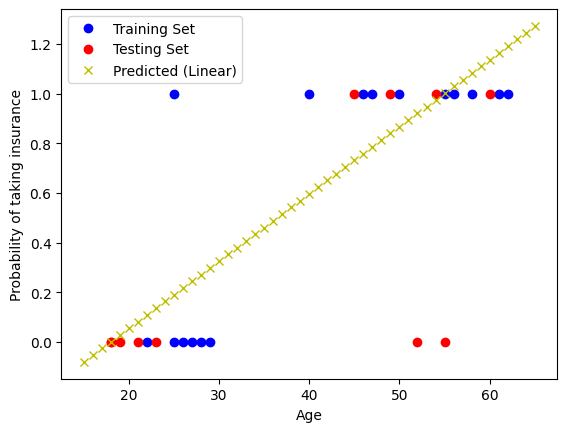

In [78]:
import numpy as np
from sklearn.linear_model import LinearRegression  # Linear Regression Model

linreg = LinearRegression() # Initialize linear model
linreg.fit(X_train, y_train)  # Fit the linear model to training data

# Fetch model predictions
ages = range(15, 66)
y_preds_linear = []

for age in ages:
    y_preds_linear.append(linreg.predict([[age]]))

# Plot predictions against actual values
plt.plot(X_train, y_train, 'bo', label="Training Set")
plt.plot(X_test, y_test, 'ro', label="Testing Set")
plt.plot(ages, y_preds_linear, 'yx', label="Predicted (Linear)")
plt.xlabel('Age')
plt.ylabel('Probability of taking insurance')
plt.legend()
plt.show()

# The problem with linear regression

We can see in the above graph that linear regression tries to fit a line to inherently non-linear data. There is another problem, however. Remember that <b>the output of classification algorithms is a probability</b>, but our linear model is predicting negative values for ages below 10, and values greater than 1 for ages greater than 55. Both are invalid probability values.

So, a line is not the answer. The question is, can we do better? According to what we have seen so far, we need to fit the data to a curve that has the following 2 properties:

- The curve must stay between 0 and 1.
- The curve must fit the two “plateaus” of the data

Finding curves that are always between 0 and 1 is not very difficult. For example, sin(x) and cos(x) are always in the interval [0,1]. However, the main challenge is in finding a curve that also has the general shape of this type of data. Luckily, there is a family of curves called <b>sigmoid curves</b> that meets both these criteria.

# Sigmoid Curves

The equation of a sigmoid curve is:

$$sigmoid(x) = \frac{1}{1+e^{-x}}$$
$$sigmoid(f(x)) = \frac{1}{1+e^{-f(x)}}$$

Let us verify that a sigmoid curve meets the two properties we discussed in the last cell.

- The curve must stay between 0 and 1
    - As x goes to ∞, e<sup>-x</sup> goes to 0, and thus sigmoid(x) tends to 1/(1+0) = 1.
    - As x goes to -∞, e<sup>-x</sup> goes to ∞, and thus sigmoid(x) tends to 1/(1+∞) = 0.
    - As x goes to 0, e<sup>-x</sup> goes to 1, and thus sigmoid(x) tends to 1/(1+1) = 1/2.
    - In all cases, the curve stays between [0,1]
- The curve must fit the two "plateaus" of the data
    - As we will see in the next section, "Plotting a sigmoid curve", The shape of a sigmoid curve is S-like: it has two plateaus that extend to infinity in either direction, and a steep ascent that joins the two plateaus. This is very similar to the shape of the data we saw before.

## Plotting a sigmoid curve

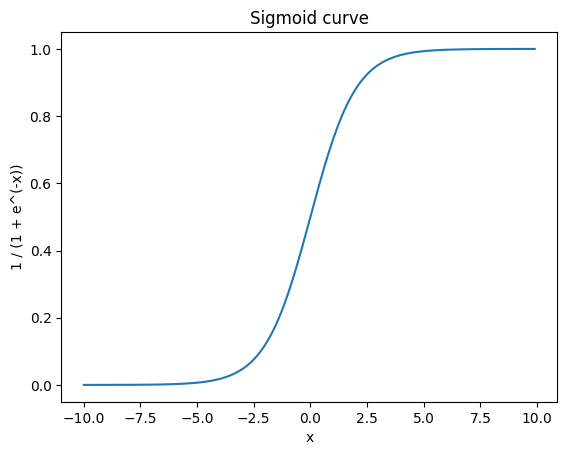

In [73]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-10, 10, 0.1) # We will plot the sigmoid curve over the range [-10, 10]

# Returns 1 / (1 + e^-z)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Plot the sigmoid
plt.plot(x, [sigmoid(x) for x in x])
plt.xlabel('x')
plt.ylabel('1 / (1 + e^(-x))')
plt.title('Sigmoid curve')
plt.show()

# Sigmoid curves and logistic regression

The primary difference between linear and logistic regression is that the latter fits a sigmoid curve to the data rather than a straight line. In linear regression, we saw that the model:

$$y=θ^{T}x$$

Where θ was the parameter vector that we optimized. In logistic regression, the model is:

$$y=\frac{1}{1+e^{θ^{T}x}}$$

The model has to learn the correct values of θ which produce the correct-shaped sigmoid curve that minimizes the loss between the predicted values and actual values. Speaking of loss...

# Logistic Regression Loss

In linear regression, we took the squared distance between the predicted and actual values as our loss function. This loss function works well for outputs that are continuous but fails to capture the essence of classification. When performing classification, the model outputs the probability that a quantity is in a class. 

Let's suppose an object X is in class C. Then the real Pr(X ∈ C) -- probability that X is in C -- is 1. If the model predicts Pr(X ∈ C)=0.5, the squared distance between the real and predicted is (1-0.5)<sup>2</sup>=0.25. Instead, if the model predicts that Pr(X ∈ C)=0, it means that the model is certain that X is NOT in C. This is an extremely inaccurate prediction. However, the squared distance between this prediction and the real value, which is (1-0)<sup>2</sup>=1, is only 4 times greater than when the model predicted 0.5. Was this prediction only 4 times as bad as when the model was unsure?

We need a loss function that captures the extremities of classification. If the model confidently asserts an object to be in a different class than the one it is truly in, we need the loss function to penalize the model harshly. Consider the following loss function. If the actual value is 1:

$$Loss(pred) = -log(pred)$$

If the actual value is 0,

$$Loss(pred) = -log(1 - pred)$$

Let us plot the two functions first:

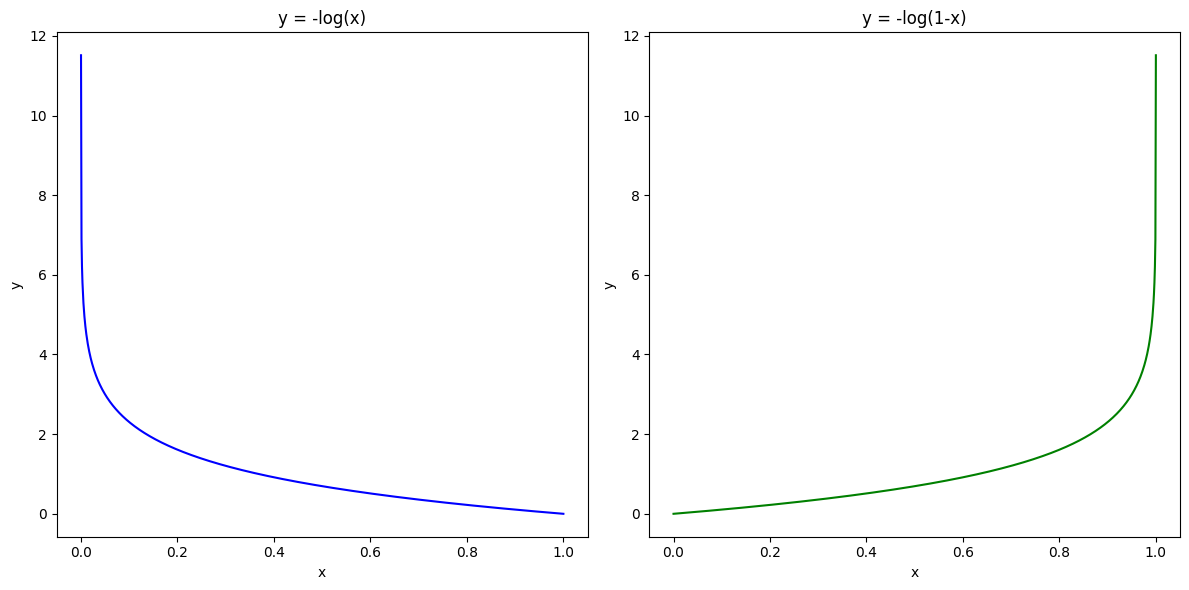

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the domain excluding 0 and 1 to avoid undefined points
x1 = np.linspace(0.00001, 1, 1000)  # Avoid x=0 for -log(x)
x2 = np.linspace(0, 0.99999, 1000)  # Avoid x=1 for -log(1-x)

# Define the functions
y1 = -np.log(x1)
y2 = -np.log(1 - x2)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot y = -log(x)
axes[0].plot(x1, y1, color='blue')
axes[0].set_title('y = -log(x)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Plot y = -log(1-x)
axes[1].plot(x2, y2, color='green')
axes[1].set_title('y = -log(1-x)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

As evident by the loss functions, the loss value increases exponentially as the predicted probability ventures further and further away from the correct class. This makes it a more suitable loss function for logistic regression.

# Logistic Regression in Python

Python's scikit-learn library allows us to implement logistic regression using the sklearn.linear_model.LogisticRegression class. The procedure, as well the difference between the output models of logistic and linear regression, are shown below:

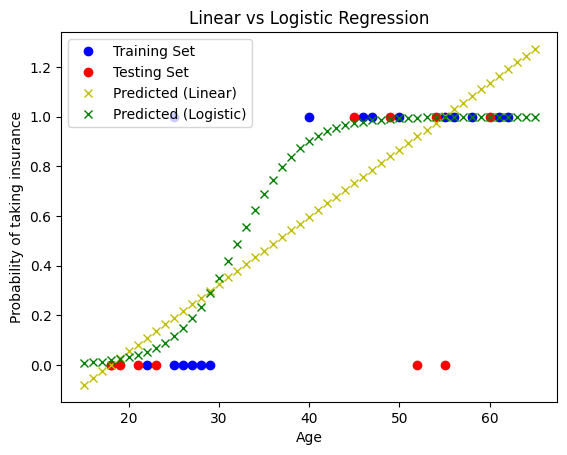

In [77]:
import numpy as np
from sklearn.linear_model import LinearRegression  # Linear Regression Model
from sklearn.linear_model import LogisticRegression  # Logistic Regression Model

linreg = LinearRegression()  # Initialize linear model
linreg.fit(X_train, y_train)  # Fit the linear model to training data

logreg = LogisticRegression()  # Initialize logistic model
logreg.fit(X_train, y_train)  # Fit the logistic model to training data

# Extract learned parameters from logistic regression model
m = logreg.coef_[0][0]
c = logreg.intercept_[0]

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

'''
Returns output probability of logistic regression.

Note that we are not using the logreg.predict() sklearn function 
to fetch the prediction like we did for linear regression. This 
is because for logistic regression, the predict function returns 
a 0/1 value, and not the actual probability.

Hence, we have to fetch the learned parameters from the logistic
regression model and feed them into a sigmoid curve ourselves.
'''
def pred_logistic(x):
    z = m * x + c
    return sigmoid(z)

# Fetch model predictions
ages = range(15, 66)
y_preds_linear = []
y_preds_logistic = []

for age in ages:
    y_preds_linear.append(linreg.predict([[age]]))  # Linear Regression prediction
    y_preds_logistic.append(pred_logistic(age))  # Logistic Regression prediction

# Plot predictions against actual values
plt.plot(X_train, y_train, 'bo', label="Training Set")
plt.plot(X_test, y_test, 'ro', label="Testing Set")
plt.plot(ages, y_preds_linear, 'yx', label="Predicted (Linear)")
plt.plot(ages, y_preds_logistic, 'gx', label="Predicted (Logistic)")
plt.xlabel('Age')
plt.ylabel('Probability of taking insurance')
plt.title('Linear vs Logistic Regression')
plt.legend()
plt.show()

# Assessing Classification Performance

There are 4 main metrics used to assess classification performance: accuracy, recall, precision, and the F-1 score.

## Accuracy

Represents the percentage of examples for which the model correctly predicted its class

$$Accuracy = \frac{correctPredictions}{totalPredictions}$$

The key issue with classification accuracy is in predicting rare occurrences. For example, if we are training a model to predict Huntington's disease (an extremely rare disease with an occurrence rate of 1-4 in every 100,000 people) in a patient, the model might learn that since more than 99% of cases don't have Huntington's, it might optimize for accuracy by predicting every case as negative. That way, just from the sheer fact that most people do not have Huntington's, its classification accuracy will be more than 99%.

To account for this issue, two more sensitive metrics have been developed - recall and precision.

## Recall

$$Recall = \frac{truePositives}{truePositives+falseNegatives}$$

In intuitive way to think about recall is: Of all the examples that were truly positive, how many did the model classify as positive? Continuing with the Huntington's example, a model that always predicts 0 for Huntington's would have a good accuracy score but a recall of 0, since it would not catch any of the positive examples.

## Precision

$$Precision = \frac{truePositives}{truePositives+falsePositives}$$

To understand precision, we can ask: Of all the examples where the model predicted positive, how many of them were truly positive? 

## Precision-Recall Tradeoff

Precision and recall are often in tension, as many attempts to increase one might decrease the other. To comprehend this better, we can use the analogy of a fishing net. If our fishing net is very wide, we will catch all the fish in the sea (high recall), but in the process, a lot of unwanted junk might also be caught by the net (low precision). On the other hand, a small and targeted fishing net will only catch the fish we want instead of roping in additional junk (high precision), but due to the small size, a lot of fish might escape (low recall).

To address this tradeoff, a more accurate assessment of classification performance is the F-1 score, a metric which factors in both precision and recall.

## F-1 Score

$$F1 = 2 * \frac{precision * recall}{precision + recall}$$